In [1]:
# !pip install kagglehub
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("nmtclone/rsna-ich-mil")

# print("Path to dataset files:", path)
# # Move from src to des
# src = path + "/rsna-ich-mil/"
# dest = "/root/rsna-ich-mil/"

# mv = "mv " + src + " " + dest
# mv

# Import Libraries

In [2]:
!pip install gpytorch torchsummary iterative-stratification optuna
!pip install torch pydicom pandas scikit-learn scikit-image numpy opencv-python matplotlib

In [3]:
import optuna
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
# from torchvision.transforms import v2 as transforms
from torchvision import transforms
from pytorch_metric_learning import losses
# from torch.cpu.amp import GradScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, multilabel_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

import sys
sys.path.append('../')

from models.mil_resnet import CNN_ATT_GP_Multilabel, CNN_ATT_GP, CNN_ATT_GP_MIML
from utils import hard_negative_mining as hnm
import gpytorch
from layers.gaussian_process import SingletaskGPModel, PGLikelihood
from utils.early_stopping import EarlyStoppingForOptimization, EarlyStopping

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import gc
torch.cuda.empty_cache()
gc.collect()

/home/hskha23/miniconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


20

In [4]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Configurations
## GPU Configurations

In [5]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: NVIDIA GeForce RTX 4070 SUPER is available.
cuda


In [6]:
%load_ext autoreload
%autoreload 2

## Seed Everything

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything()

## Constants and Hyperparameters

In [8]:
import yaml

with open("../config.yaml") as file:
    config = yaml.safe_load(file)

# Accessing constants from config
HEIGHT = config['height']
WIDTH = config['width']
CHANNELS = config['channels']

TRAIN_BATCH_SIZE = config['train_batch_size']
VALID_BATCH_SIZE = config['valid_batch_size']
TEST_BATCH_SIZE = config['test_batch_size']
TEST_SIZE = config['test_size']
VALID_SIZE = config['valid_size']

TRAINING_TYPE = config['training_type']
GP_MODEL = config['gp_model']
GP_KERNEL = config['kernel_type']
MODEL_TYPE = config['model_type']
CONTRASTIVE_LEARNING = config['contrastive_learning']

MAX_SLICES = config['max_slices']
SHAPE = tuple(config['shape'])

NUM_EPOCHS = config['num_epochs']
LEARNING_RATE = config['learning_rate']
LEARNING_RATE_NGD = config['learning_rate_ngd']
INDUCING_POINTS = config['inducing_points']
THRESHOLD = config['threshold']

NUM_CLASSES = config['num_classes']

TARGET_LABELS = config['target_labels']

# MODEL_PATH = config['model_path']
MODEL_PATH = '../rsna/results/trained_model.pth'
LIKELIHOOD_PATH = config['likelihood_path']
DEVICE = config['device']

PROJECTION_LOCATION = config['projection_location']
PROJECTION_HIDDEN_DIM = config['projection_hidden_dim']
PROJECTION_OUTPUT_DIM = config['projection_output_dim']

ATTENTION_HIDDEN_DIM = config['attention_hidden_dim']

In [9]:
KAGGLE = os.path.exists(('kaggle/input'))
REMOTE_SERVER = os.path.exists(('/workspace/rsna-ich-mil'))
CQ500 = 1
ROOT_DIR = None
# DATA_DIR = ROOT_DIR + 'rsna-mil-training/' if KAGGLE else '../rsna-ich-mil/'
if KAGGLE:
  DATA_DIR = ROOT_DIR + 'rsna-mil-training/'
  DICOM_DIR = DATA_DIR
  CSV_PATH = DICOM_DIR + 'training_1000_scan_subset.csv'
elif REMOTE_SERVER:
  DATA_DIR = '/root/.cache/kagglehub/datasets/nmtclone/rsna-ich-mil/versions/4/rsna-ich-mil/'
  DICOM_DIR = DATA_DIR
  CSV_PATH = '/workspace/Brain-Stroke-Diagnosis/rsna/data_analyze/training_dataset_2_redundancy_1150_for_kaggle.csv'
  print('Running on remote server.')
elif CQ500:
  DATA_DIR = '/archive/'
  DICOM_DIR = DATA_DIR
  CSV_PATH = 'data/cq500_redundancy.csv'
  print('Running on CQ500.')
else:
  DATA_DIR = '../rsna-ich-mil/'
  DICOM_DIR = DATA_DIR
  CSV_PATH = './data_analyze/training_dataset_2_redundancy.csv'

# CSV_PATH = DICOM_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_dataset_2_redundancy.csv'
# patient_scan_labels = pd.read_csv(CSV_PATH, nrows=1150)
patient_scan_labels = pd.read_csv(CSV_PATH)
dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR

Running on CQ500.


In [10]:
patient_scan_labels.head()

,name,Category,R1:ICH,R1:IPH,R1:IVH,R1:SDH,R1:EDH,R1:SAH,R1:BleedLocation-Left,R1:BleedLocation-Right,...,patient_BleedLocation-Right,patient_ChronicBleed,patient_Fracture,patient_CalvarialFracture,patient_OtherFracture,patient_MassEffect,patient_MidlineShift,filename,img_pos,patient_label
0,CQ500CT427,B2,1,1,0,0,0,0,0,1,...,1,0,0,0,0,1,0,"['CT000028.dcm', 'CT000021.dcm', 'CT000030.dcm...","['[-125.0, -113.84, 3.59]', '[-125.0, -113.84,...",1
1,CQ500CT181,B2,1,1,0,1,0,1,1,0,...,0,0,1,1,0,1,1,"['CT000030.dcm', 'CT000029.dcm', 'CT000031.dcm...","['[-125.0, -128.362, 0.97]', '[-125.0, -128.36...",1
2,CQ500CT99,B1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"['CT000021.dcm', 'CT000002.dcm', 'CT000000.dcm...","['[-131.5, -155.4, -58.75]', '[-131.5, -155.4,...",0
3,CQ500CT47,B1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"['CT000003.dcm', 'CT000000.dcm', 'CT000028.dcm...","['[-112.0, -135.0, -11.75]', '[-112.0, -135.0,...",0
4,CQ500CT195,B1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"['CT000026.dcm', 'CT000004.dcm', 'CT000012.dcm...","['[-110.5, -126.8, -17.5]', '[-110.5, -126.8, ...",0


# Data Preprocessing
## Splitting Data

In [11]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels['patient_label']
    if test_size > 0:
        # First, split off the test set
        train_val_labels, test_labels = train_test_split(
            patient_scan_labels,
            test_size=test_size,
            stratify=labels,
            random_state=random_state
        )

        # Calculate the validation size relative to the train_val set
        val_size_adjusted = val_size / (1 - test_size)

        # Split the train_val set into train and validation sets
        train_labels, val_labels = train_test_split(
            train_val_labels,
            test_size=val_size_adjusted,
            stratify=train_val_labels['patient_label'],
            random_state=random_state
        )
    else:
        train_labels, val_labels = train_test_split(
            patient_scan_labels,
            test_size=val_size,
            stratify=labels,
            random_state=random_state
        )
        test_labels = None

    return train_labels, val_labels, test_labels

from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

def split_dataset_for_multilabel(patient_scan_labels, test_size=0.15, val_size=0.25, random_state=42):
    # Extract the labels from the DataFrame
    # labels = patient_scan_labels[['patient_any', 'patient_epidural', 'patient_intraparenchymal',
    #                               'patient_intraventricular', 'patient_subarachnoid', 'patient_subdural']].values
    prefix = 'patient_'
    # postfix = ['ICH', 'IPH', 'IVH', 'SDH', 'EDH', 'SAH', 'BleedLocation-Left', 'BleedLocation-Right', 'ChronicBleed', 'Fracture', 'CalvarialFracture', 'OtherFracture', 'MassEffect', 'MidlineShift']
    postfix = ['ICH', 'IPH', 'IVH', 'SDH', 'EDH', 'SAH']
    labels = patient_scan_labels[[prefix + p for p in postfix]].values

    if test_size > 0:
        # First split: train + test
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(msss.split(patient_scan_labels, labels))

        train_labels = patient_scan_labels.iloc[train_idx]
        test_labels = patient_scan_labels.iloc[test_idx]

        # Second split: train + validation
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(train_labels, labels[train_idx]))

        train_labels_final = train_labels.iloc[train_idx]
        val_labels = train_labels.iloc[val_idx]

    else:
        # Only split into train and validation if test_size is 0
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(patient_scan_labels, labels))

        train_labels_final = patient_scan_labels.iloc[train_idx]
        val_labels = patient_scan_labels.iloc[val_idx]
        test_labels = None

    return train_labels_final, val_labels, test_labels

## Dataset Generator

In [12]:
# from dataset_generators.RSNA_Dataset import MedicalScanDataset
from dataset_generators.CQ500_Dataset import CQ500Dataset

In [13]:
class TrainDatasetGenerator(CQ500Dataset):
    """Dataset class for training medical scan data."""

    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)


class TestDatasetGenerator(CQ500Dataset):
    """Dataset class for testing medical scan data."""

    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)

In [14]:
original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)

In [15]:
len(original_dataset)

472

In [16]:
x, _, z, t = original_dataset[0]
print(x.shape, z.shape, t.shape)

torch.Size([32, 1, 224, 224]) torch.Size([]) torch.Size([6])


In [17]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE):
    # original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=augmentor)
    original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,
                      drop_last=True)


def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

# Training and Validation
## Metrics Calculation
### Performance Metrics

In [18]:
def calculate_metrics(predictions, labels):
    if NUM_CLASSES == 1:
        return {
            "accuracy": accuracy_score(labels, predictions),
            "precision": precision_score(labels, predictions, average='weighted'),
            "recall": recall_score(labels, predictions, average='weighted'),
            "f1": f1_score(labels, predictions, average='weighted'),
            "auc": roc_auc_score(labels, predictions)
        }
    else:
        return {
            "accuracy": accuracy_score(labels, predictions),
            "precision": precision_score(labels, predictions, average='samples'),
            "recall": recall_score(labels, predictions, average='samples'),
            "f1": f1_score(labels, predictions, average='samples'),
            "auc": roc_auc_score(labels, predictions)
        }


def print_epoch_stats(epoch, num_epochs, phase, loss, metrics):
    """Print statistics for an epoch."""
    print(f"Epoch {epoch + 1}/{num_epochs} - {phase.capitalize()}:")
    print(f"Loss: {loss:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}, AUC: {metrics['auc']:.4f}")

### Loss Function

In [19]:
def combined_loss(outputs, gp_distribution, target, alpha=0.5):
    if CHANNELS == 1:
        bce_loss_fn = nn.BCEWithLogitsLoss()
        bce_loss = bce_loss_fn(outputs.squeeze(), target.float())
        kl_divergence = gp_distribution.variational_strategy.kl_divergence()
        total_loss = (1 - alpha) * bce_loss + alpha * kl_divergence
    else:
        ce_loss_fn = nn.CrossEntropyLoss()
        ce_loss = ce_loss_fn(outputs.squeeze(), target.float())
        kl_divergence = gp_distribution.variational_strategy.kl_divergence()
        total_loss = (1 - alpha) * ce_loss + alpha * kl_divergence

    return total_loss

## Training Loop

In [20]:
from tqdm import tqdm  # Add this import at the top of your file

def train_epoch(model, likelihoods, data_loader, criterion_cl, criterion_bce, mlls, optimizer, variational_ngd_optimizer, scheduler,
                scaler, device):
    total_loss = 0.0
    total_nlls = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    model.train()
    likelihoods.train()

    # for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
    for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in tqdm(data_loader):
        batch_data = batch_data.to(device)
        batch_patient_labels = batch_patient_labels.float().to(device)
        batch_multi_labels = batch_multi_labels.float().to(device)
        optimizer.zero_grad()

        if GP_MODEL == 'single_task':
            for i in range(NUM_CLASSES):
                variational_ngd_optimizer[i].zero_grad()

        if TRAINING_TYPE == 'end_to_end':
            outputs, gp_outputs, att_outputs = model(batch_data)

            if GP_MODEL == 'single_task':
                if NUM_CLASSES == 1:
                    loss = -0.5 * mlls(gp_outputs, batch_multi_labels) + 0.5 * criterion_bce(outputs, batch_patient_labels)
                    loss = loss.mean()
                    probabilities = likelihoods(gp_outputs).probs
                else:
                    loss = 0
                    for i in range(NUM_CLASSES):
                        loss += -mlls[i](gp_outputs[i], batch_multi_labels[:, i])
                    loss.mean()
                    loss += 0.5 * criterion_bce(outputs, batch_multi_labels)

                    probs = [likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)]
                    probabilities = torch.stack(probs, dim=1)
                preds = (probabilities >= 0.5).int()

            else:
                loss = -mlls(gp_outputs, batch_multi_labels) * 0.5 + 0.5 * criterion_bce(outputs, batch_multi_labels)
                loss = loss.mean()
                preds = (outputs >= 0.5).int()

            predictions.extend(preds.cpu().detach().numpy())

            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            if GP_MODEL == 'single_task':
                for i in range(NUM_CLASSES):
                    variational_ngd_optimizer[i].step()
            scheduler.step()

        if NUM_CLASSES == 1:
            labels.extend(batch_patient_labels.cpu().numpy())
        else:
            labels.extend(batch_multi_labels.cpu().numpy())

    return total_loss / len(data_loader), predictions, labels


def validate(model, likelihoods, data_loader, criterion_cl, criterion_bce, mlls, device):
    """Validate the model."""
    model.eval()
    likelihoods.eval()

    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    with torch.inference_mode():
        # for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in tqdm(data_loader):
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                outputs, gp_outputs, att_outputs = model(batch_data)
                if GP_MODEL == 'single_task':
                    if NUM_CLASSES != 1:
                        loss = 0
                        for i in range(NUM_CLASSES):
                            loss += -mlls[i](gp_outputs[i], batch_multi_labels[:, i])
                        loss.mean()
                        loss += 0.5 * criterion_bce(outputs, batch_multi_labels)
                        probabilities = torch.stack([likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)], dim=1)

                    else:
                        loss = -0.5 * mlls(gp_outputs, batch_multi_labels) + 0.5 * criterion_bce(outputs, batch_patient_labels)
                        probabilities = likelihoods(gp_outputs).probs

                    preds = (probabilities >= 0.5).int()
                else:
                    loss = -mlls(gp_outputs, batch_multi_labels) * 0.5 + 0.5 * criterion_bce(outputs, batch_multi_labels)
                    preds = (outputs >= 0.5).int()

                loss = loss.mean()
                total_loss += loss.item()
                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())
    return total_loss / len(data_loader), predictions, labels


def train_model(model, likelihoods, train_loader, val_loader, criterion_cl, criterion_bce, optimizer, num_epochs, learning_rate,
                device='cuda'):
    """Train the model and return the best model based on validation accuracy."""
    model = model.to(device)
    model.train()
    likelihoods.train()

    # Initialize Early Stopping
    early_stopping = EarlyStopping(patience=10, verbose=True)

    if GP_MODEL == 'single_task':
        mlls = [gpytorch.mlls.VariationalELBO(likelihoods[i], model.gp_layers[i], num_data=len(train_loader.dataset)) for
                i in range(NUM_CLASSES)]
        mlls = [mll.to(device) for mll in mlls]

        variational_ngd_optimizer = [
            gpytorch.optim.NGD(model.gp_layers[i].variational_parameters(), num_data=len(train_loader.dataset),
                               lr=0.01) for i in range(NUM_CLASSES)]
    else:
        mlls = gpytorch.mlls.VariationalELBO(likelihoods, model.gp_layers, num_data=len(train_loader.dataset))
        mlls = mlls.to(device)
        variational_ngd_optimizer = None

    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)

    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * num_epochs, 0.75 * num_epochs], gamma=0.1)

    # scaler = torch.amp.GradScaler('cuda')
    scaler = None
    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_predictions, train_labels = train_epoch(model, likelihoods, train_loader, criterion_cl, criterion_bce,
                                                                  mlls, optimizer, variational_ngd_optimizer,
                                                                  scheduler, scaler, device)
        train_metrics = calculate_metrics(train_predictions, train_labels)
        print_epoch_stats(epoch, num_epochs, "train", train_loss, train_metrics)
        # Log training metrics to W&B
        wandb.log({
            "train/loss": train_loss,
            "train/accuracy": train_metrics["accuracy"],
            "train/precision": train_metrics["precision"],
            "train/recall": train_metrics["recall"],
            "train/f1": train_metrics["f1"],
        })

        # Validation phase
        val_loss, val_predictions, val_labels = validate(model, likelihoods, val_loader, criterion_cl, criterion_bce, mlls,
                                                         device)
        val_metrics = calculate_metrics(val_predictions, val_labels)
        print_epoch_stats(epoch, num_epochs, "validation", val_loss, val_metrics)
        # Log validation metrics to W&B
        wandb.log({
            "val/loss": val_loss,
            "val/accuracy": val_metrics["accuracy"],
            "val/precision": val_metrics["precision"],
            "val/recall": val_metrics["recall"],
            "val/f1": val_metrics["f1"],
        })

        # Early Stopping Check
        early_stopping(val_metrics["f1"], model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = model.state_dict()

    # Load best model
    model.load_state_dict(best_model_state)
    # Optionally log the best model to W&B (if desired)
    print(f'Best Validation Accuracy: {best_val_accuracy}')
    wandb.log_artifact(wandb.Artifact("best_model", type="model", metadata={"accuracy": best_val_accuracy}))

    return model

## Model Evaluation

In [21]:
## Model Evaluation Functions
def evaluate_model(model, likelihoods, data_loader, device='cuda'):
    """Evaluate the model on the given data loader."""
    model = model.to(device)
    likelihoods = likelihoods.to(device)
    model.eval()
    likelihoods.eval()

    predictions = []
    labels = []
    probs = []

    with torch.inference_mode():
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                outputs, gp_outputs, att_outputs = model(batch_data)
                if GP_MODEL == 'single_task':
                    if NUM_CLASSES > 1:
                        probabilities = torch.stack([likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)], dim=1)
                    else:
                        probabilities = likelihoods(gp_outputs).probs
                    preds = (probabilities >= THRESHOLD).int()
                    # preds = (torch.sigmoid(outputs) >= THRESHOLD).int()
                else:
                    outputs = torch.sigmoid(outputs)
                    preds = (outputs >= THRESHOLD).int()
                    probabilities = outputs
                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

            probs.extend(probabilities.cpu().detach().numpy())

    return np.array(predictions), np.array(labels), np.array(probs)


def print_metrics(metrics):
    """Print the calculated metrics."""
    print(f"Test Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}",
          f"AUC: {metrics['auc']:.4f}")

In [22]:
## Visualization Functions
def plot_roc_curve(model, likelihoods, data_loader, device):
    """Plot the ROC curve for the model predictions."""
    model.eval()
    likelihoods.eval()
    labels = []
    predictions = []

    with torch.no_grad():
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                outputs, gp_outputs, _ = model(batch_data)
                if GP_MODEL == 'single_task':
                    if NUM_CLASSES > 1:
                        probabilities = torch.stack([likelihoods[i](gp_outputs[i]).probs for i in range(NUM_CLASSES)], dim=1)
                    else:
                        probabilities = likelihoods(gp_outputs).probs
                    preds = probabilities

                else:
                    outputs = torch.sigmoid(outputs)
                    preds = outputs
                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:  # Binary classification
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

    labels = np.array(labels)
    predictions = np.array(predictions)

    if NUM_CLASSES == 1:
        fpr, tpr, _ = roc_curve(labels, predictions)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    else:
        class_name = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        for i in range(NUM_CLASSES):
            fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2,
                    label=f'Class {class_name[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()


# def plot_confusion_matrix(model, likelihoods, data_loader, device):
#     """Plot the confusion matrix for the model predictions."""
#     predictions, labels, _ = evaluate_model(model, likelihoods, data_loader, device)
#
#     cm = confusion_matrix(labels, predictions)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot()
#     plt.title('Confusion Matrix')
#     plt.show()
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(model, likelihoods, data_loader, device):
    """Plot confusion matrix for classification tasks."""
    predictions, labels, _ = evaluate_model(model, likelihoods, data_loader, device)

    if NUM_CLASSES > 1:  # Multi-label/multi-class
        cm = multilabel_confusion_matrix(labels, predictions)
        _, ax = plt.subplots(1, NUM_CLASSES, figsize=(15, 3))
        for i in range(NUM_CLASSES):
            ConfusionMatrixDisplay(cm[i]).plot(ax=ax[i])
            ax[i].set_title(f'Class {i}')
    else:  # Binary
        cm = confusion_matrix(labels, predictions)
        ConfusionMatrixDisplay(cm).plot()

    plt.tight_layout()
    plt.show()

# Model Helper Functions

In [23]:
## Data Processing Functions
def load_model(model_class, model_path, params):
    """Load a trained model from a file."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    model = model_class(params)
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cuda'), weights_only=True)
        if not state_dict:
            raise ValueError(f"The state dictionary loaded from {model_path} is empty")
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Initializing model with random weights instead.")
        return model  # Return the model with random initialization

    return model.eval()


def get_test_results(model, test_loader, test_labels, device=DEVICE):
    """Get test results including patient information."""
    predictions, _ = evaluate_model(model, test_loader, device)

    results = []
    for i, row in enumerate(test_labels.itertuples(index=False)):
        result = {col: getattr(row, col) for col in test_labels.columns}
        result['prediction'] = predictions[i]
        results.append(result)

    return pd.DataFrame(results)

## NTXentLoss

In [24]:
class NTXentLoss(losses.NTXentLoss):
    def __init__(self, temperature, **kwargs):
        super().__init__(temperature=temperature, **kwargs)
        self.temperature = temperature

    def forward(self, embeddings, labels=None, hard_pairs=None):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(embeddings, p=2, dim=1)

        if labels == None:
            # Self-supervised labels
            batch_size = feature_vectors_normalized.size(0) // 2  # Assuming equal size for both embeddings
            labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)], dim=0)

        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )

        if labels == None:
            return losses.NTXentLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        if hard_pairs == None:
            return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels), hard_pairs)

# Main

In [27]:
from datetime import datetime

def main(mode='train', use_cv=False, num_folds=5):
    # os.environ["WANDB_DISABLED"] = "true"
    current_time = datetime.now().strftime("%Y%m%d_%H%M")
    run_name = f"experiment_{current_time}_{GP_MODEL}_refiner_fc_{PROJECTION_HIDDEN_DIM}_output_{PROJECTION_OUTPUT_DIM}_attention_{ATTENTION_HIDDEN_DIM}_kernel_{GP_KERNEL}_model_{MODEL_TYPE}"

    # Initialize W&B with a specific run name
    wandb.init(project="MIL_Resnet_ICH", name=run_name)

    # Log hyperparameters
    config = wandb.config
    config.learning_rate = LEARNING_RATE
    config.batch_size = TRAIN_BATCH_SIZE
    config.num_epochs = NUM_EPOCHS

    params = {
        'channels': CHANNELS,  # Number of input channels (e.g., 1 for grayscale, 3 for RGB)
        'num_classes': NUM_CLASSES,  # Number of output classes for classification
        'drop_prob': 0.5,  # Dropout probability
        'inducing_points': INDUCING_POINTS,  # Number of inducing points for the Gaussian Process layer
        'projection_location': PROJECTION_LOCATION,  # Choose from 'after_resnet', 'after_attention', or 'after_gp'
        'projection_hidden_dim': PROJECTION_HIDDEN_DIM,  # Hidden dimension size for the projection head
        'projection_output_dim': PROJECTION_OUTPUT_DIM,  # Output dimension size for the projection head
        'attention_hidden_dim': ATTENTION_HIDDEN_DIM,  # Hidden dimension size for the attention head
        'gp_model': GP_MODEL,
        'kernel_type': GP_KERNEL,
        'model_type': MODEL_TYPE,
        'contrastive_learning': CONTRASTIVE_LEARNING
    }

    if use_cv == False:
        if mode == 'train':
            train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
            # test_labels = pd.read_csv('./rsna/data_analyze/testing_dataset_150_redundancy.csv')
            # train_labels, val_labels, test_labels = split_dataset_for_multilabel(patient_scan_labels, test_size=TEST_SIZE)

            train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
            val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
            test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)
        else:
            test_labels = pd.read_csv('data/cq500_redundancy.csv')
            test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)

        if TRAINING_TYPE == 'end_to_end':
            if GP_MODEL == 'single_task':
                model = CNN_ATT_GP_Multilabel(params)
                if NUM_CLASSES != 1:
                    likelihood = nn.ModuleList([PGLikelihood() for _ in range(NUM_CLASSES)])
                else:
                    # likelihood = PGLikelihood()
                    likelihood = gpytorch.likelihoods.BernoulliLikelihood()
                optimizer = optim.Adam([
                    {'params': model.parameters(), 'lr': config.learning_rate},
                    {'params': likelihood.parameters(), 'lr': config.learning_rate}
                ])
            elif GP_MODEL == 'multi_task':
                model = CNN_ATT_GP_MIML(params)
                # likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=NUM_CLASSES)
                likelihood = gpytorch.likelihoods.BernoulliLikelihood()
                optimizer = optim.Adam([
                    {'params': model.parameters(), 'lr': config.learning_rate},
                    {'params': likelihood.parameters(), 'lr': config.learning_rate}
                ])


        criterion_cl = NTXentLoss(0.5)
        if NUM_CLASSES == 1:
            pos_weights = torch.tensor([2.0]).to(DEVICE)
        else:
            pos_weights = torch.tensor([2.0] * NUM_CLASSES).to(DEVICE)
        criterion_bce = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        criterion_bce_wll = nn.BCEWithLogitsLoss()

        if mode == 'train':
            if TRAINING_TYPE == 'end_to_end':
                wandb.watch(model)  # Watch the model to log gradients and parameters
                trained_model, likelihood = train_model(model, likelihood, train_loader, val_loader, criterion_cl, criterion_bce,
                                            optimizer, config.num_epochs, config.learning_rate, DEVICE)

                predictions, labels, _ = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
                metrics = calculate_metrics(predictions, labels)
                wandb.log(metrics)
                print_metrics(metrics)

                plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
                plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)
                torch.save(trained_model.state_dict(), MODEL_PATH)
                torch.save(likelihood.state_dict(), LIKELIHOOD_PATH)

        if TRAINING_TYPE == 'end_to_end':
            if GP_MODEL == 'single_task':
                trained_model = load_model(CNN_ATT_GP_Multilabel, MODEL_PATH, params)
            elif GP_MODEL == 'multi_task':
                trained_model = load_model(CNN_ATT_GP_MIML, MODEL_PATH, params)
            else:
                trained_model = load_model(CNN_ATT_GP, MODEL_PATH, params)
            predictions, labels, probs = evaluate_model(trained_model, likelihood, test_loader, DEVICE)

        metrics = calculate_metrics(predictions, labels)
        wandb.log(metrics)
        print_metrics(metrics)

        plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
        plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)


        print("\nProbabilities for each row in the test set:")
        for i, prob in enumerate(probs):
            if NUM_CLASSES == 1:
                is_correct = predictions[i] == labels[i]
                print(f"Row {i+1}: Probs: {prob.item():.4f} | Prediction: {predictions[i]} | Label: {labels[i]} | Result: {'True' if is_correct else 'False'}")
            else:
                is_correct = np.array_equal(predictions[i], labels[i])
                print(f"Row {i+1}: Probs: {prob.tolist()} | Prediction: {predictions[i].tolist()} | Label: {labels[i].tolist()} | Result: {'True' if is_correct else 'False'}")

    else:
        if NUM_CLASSES == 1:
            # Split initial holdout test set first
            trainval_labels, test_labels, _ = split_dataset(
                patient_scan_labels,
                val_size=TEST_SIZE,
                test_size=0.0
            )
            test_labels = pd.read_csv('./rsna/data_analyze/testing_dataset_150_redundancy.csv')
        else:
            # Split initial holdout test set first
            trainval_labels, test_labels, _ = split_dataset_for_multilabel(
                patient_scan_labels,
                val_size=TEST_SIZE,
                test_size=0.0
            )

        # Setup CV using trainval data
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        fold_metrics = []

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(trainval_labels)):
            print(f"\nFold {fold_idx+1}/{num_folds}")

            # Create fold splits
            train_labels_fold = trainval_labels.iloc[train_idx]
            val_labels_fold = trainval_labels.iloc[val_idx]

            # Create data loaders
            train_loader = get_train_loader(dicom_dir, train_labels_fold, TRAIN_BATCH_SIZE)
            val_loader = get_train_loader(dicom_dir, val_labels_fold, VALID_BATCH_SIZE)
            test_loader = get_test_loader(dicom_dir, test_labels, TEST_BATCH_SIZE)

            # Initialize model
            if GP_MODEL == 'single_task':
                model = CNN_ATT_GP_Multilabel(params)
                if NUM_CLASSES != 1:
                    likelihood = nn.ModuleList([PGLikelihood() for _ in range(NUM_CLASSES)])
                else:
                    likelihood = PGLikelihood()
                optimizer = optim.Adam([
                    {'params': model.parameters(), 'lr': config.learning_rate},
                    {'params': likelihood.parameters(), 'lr': config.learning_rate}
                ])
            elif GP_MODEL == 'multi_task':
                model = CNN_ATT_GP_MIML(params)
                likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=NUM_CLASSES)
                optimizer = optim.Adam([
                    {'params': model.parameters(), 'lr': config.learning_rate},
                    {'params': likelihood.parameters(), 'lr': config.learning_rate}
                ])

            criterion_cl = NTXentLoss(0.5)
            if NUM_CLASSES == 1:
                pos_weights = torch.tensor([2.0]).to(DEVICE)
            else:
                pos_weights = torch.tensor([2.0] * NUM_CLASSES).to(DEVICE)
            criterion_bce = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

            # Train model
            wandb.init(project="MIL_Resnet_ICH", name=f"{run_name}_fold_{fold_idx+1}")
            wandb.watch(model)
            trained_model, likelihood = train_model(model, likelihood, train_loader, val_loader, criterion_cl, criterion_bce,
                                        optimizer, config.num_epochs, config.learning_rate, DEVICE)

            # Evaluate model
            predictions, labels, _ = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
            metrics = calculate_metrics(predictions, labels)

            # Log metrics
            wandb.log(metrics)
            print_metrics(metrics)
            fold_metrics.append(metrics)

            plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
            plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)

            # Save model
            torch.save(trained_model.state_dict(), f"{MODEL_PATH}_fold_{fold_idx+1}")
            torch.save(likelihood.state_dict(), f"{LIKELIHOOD_PATH}_fold_{fold_idx+1}")

        # Calculate average metrics across all folds
        avg_metrics = {}
        for metric in fold_metrics[0].keys():
            avg_metrics[metric] = np.mean([fold[metric] for fold in fold_metrics])
        print("\nAverage Metrics Across All Folds:")
        print_metrics(avg_metrics)
        wandb.log(avg_metrics)

# Results

accuracy,▁
auc,▁
f1,▁
precision,▁
recall,▁
accuracy,0.75
auc,0.73016
f1,0.74167
precision,0.75909
recall,0.75


Test Accuracy: 0.7414, Precision: 0.7464, Recall: 0.7414, F1: 0.7355 AUC: 0.7271


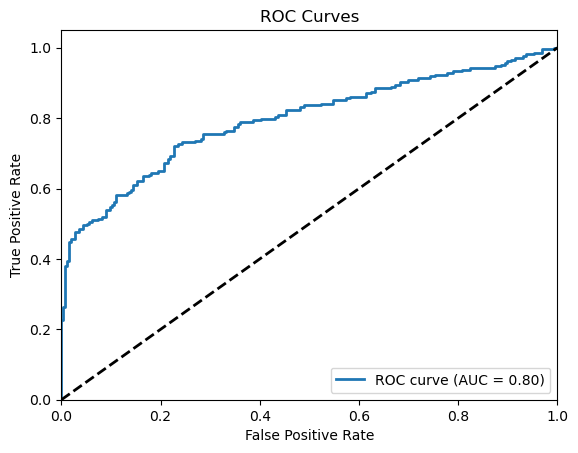

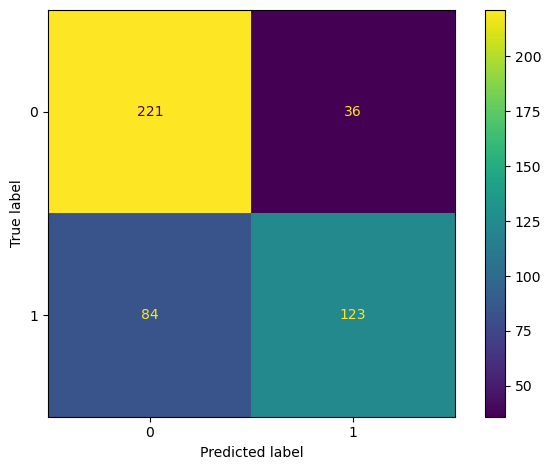


Probabilities for each row in the test set:
Row 1: Probs: 0.9936 | Prediction: 1 | Label: 1.0 | Result: True
Row 2: Probs: 0.0024 | Prediction: 0 | Label: 0.0 | Result: True
Row 3: Probs: 0.6612 | Prediction: 1 | Label: 1.0 | Result: True
Row 4: Probs: 0.0012 | Prediction: 0 | Label: 0.0 | Result: True
Row 5: Probs: 0.0011 | Prediction: 0 | Label: 1.0 | Result: False
Row 6: Probs: 0.9911 | Prediction: 1 | Label: 1.0 | Result: True
Row 7: Probs: 0.0015 | Prediction: 0 | Label: 1.0 | Result: False
Row 8: Probs: 0.7394 | Prediction: 1 | Label: 1.0 | Result: True
Row 9: Probs: 0.9970 | Prediction: 1 | Label: 1.0 | Result: True
Row 10: Probs: 0.0092 | Prediction: 0 | Label: 0.0 | Result: True
Row 11: Probs: 0.1203 | Prediction: 0 | Label: 1.0 | Result: False
Row 12: Probs: 0.3333 | Prediction: 0 | Label: 1.0 | Result: False
Row 13: Probs: 0.0013 | Prediction: 0 | Label: 0.0 | Result: True
Row 14: Probs: 0.0069 | Prediction: 0 | Label: 0.0 | Result: True
Row 15: Probs: 0.0022 | Prediction: 

In [28]:
if __name__ == "__main__":
    main(mode='test')